<a href="https://colab.research.google.com/github/prateekchandrajha/worldquant-online-algorithms/blob/main/Online_Convex_Techniques_Finance_To_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Worldquant Capstone Project

## By Prateek Chandra Jha

### Fulfilling the requirements of the Code supporting the findings in my draft WQU Capstone Project Report

### Submitted On: 19/02/2020

In [1]:
"""Importing All The Important Libraries Required for Coding Online Convex Optimization Techniques"""

from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import hinge_loss as hl
import matplotlib.pyplot as plt
import tqdm as tqdm
import seaborn as sns
import scipy as st
import random as rdm
import warnings; warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler

In [2]:
"""
UTILITY FUNCTIONS FOR CALCULATING SIMPLEX PROJECTIONS, LOSS FUNCTIONS, OTHER REQUIRED METRICS & EVALUATION FUNCTIONS
"""

digits = load_digits()
std = StandardScaler()
rdm.seed(5) # SETTING THE RANDOM SEED FOR GENERATING RANDOM NUMBERS AND THAT IT"S CONSISTENT IN SEVERAL RUNS

# PULL EACH ELEMENT IN THE LIST GREATER THAN "u" to MAXIMUM OF "u"
def pmin(u,li):
    for y in range(len(li)):
        if li[y]>u:
            li[y]=u
    return li

# PULL EACH ELEMENT IN THE LIST SMALLER THAN "u" to MINIMUM OF "u"
def pmax(u,li):
    for p in range(len(li)):
        if li[p]<u:
            li[p]=u
    return li

"""In machine learning, the hinge loss is a loss function used for training classifiers. 
The hinge loss is used for "maximum-margin" classification, most notably for support vector machines (SVMs). 
"""

def hinge_loss(x,a,b,lam):
    seuil = a.dot(x)*b
    cost = (1 - a.dot(x)*b)*( a.dot(x)*b <1)
    return lam*cost+ (x.T.dot(x))/2

"""FUNCTION CALLS RETURN GRADIENTS AND STOCHASTIC GRADIENTS"""
def gradient(x,a_t,b_t,lam):
    gradient = 0*(b_t*x.T.dot(a_t)>1) - b_t*a_t*(b_t*x.T.dot(a_t)<=1)
    return lam*gradient+x

def gradient_sca(x,a_t,b_t,lam):
    gradient = 0*(b_t*x*a_t>1) - b_t*a_t*(b_t*x*a_t<=1)
    return lam*gradient+x


"""RETURNS TOTAL LOSS WHEN "a" IS AN ARRAY AS AN ARRAY OF HINGE LOSSES"""
def total_cost(x,a,b,lam):
    s = []
    for i in range(a.shape[0]):
        s.append(hinge_loss(x,a[i,:],b[i],lam))
    return np.mean(s)



""" 
Compute the Euclidean Projection on a Positive Simplex:
    Solves the quadratic optimisation problem (using the algorithm from Elad Hazan's OCO Book):
        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s (in our case s is mostly 1, a probability simplex), w_i >= 0 
    Parameters
    ----------
    v: n-dimensional vector to project
    s: radius of the simplex
    Returns
    -------
    w: numpy array, i.e. PROJECTION
"""

def euclidean_proj_simplex(v, s=1):
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape
    if v.sum() == s and np.alltrue(v >= 0):
        return v
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
    theta = float(cssv[rho] - s) / rho
    w = (v - theta).clip(min=0)
    return w


""" 
Compute the Euclidean projection on a L1-ball:
    Solves the quadratic optimisation problem (using the algorithm from Elad Hazan's OCO Book):
        min_w 0.5 * || w - v ||_2^2 , s.t. || w ||_1 <= s

    Parameters
    ----------
    v: n-dimensional vector to project
    s: radius of the L1-ball
    Returns
    -------
    w: Euclidean projection of v on the L1-ball of radius s
    euclidean_proj_simplex
"""

def euclidean_proj_l1ball(v, s=1):
    assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
    n, = v.shape  
    u = np.abs(v)
    if u.sum() <= s:
        return v
    w = euclidean_proj_simplex(u, s=s)
    w *= np.sign(v)
    return w


"""CALCULATING THE PROJECTION OF X IN THE SUBSPACE OF W AND Z"""

def proj_w(x,w,z):
    v = np.abs(x*w)
    u = np.argsort(-v)
    sx = np.cumsum(np.abs(x)[u])
    sw = np.cumsum(1/w[u])
    rho = np.max( np.where(v[u]>(sx-z)/sw) )
    theta = (sx[rho] - z)/sw[rho]
    if (sum(np.abs(x))>z):
        x = np.sign(x)*pmax(0,np.abs(x)-theta/w)
    return x

- WRITING A TEST FUNCTION TO RETURN ACCURACY AND LOSS METRICS

- ALSO A SVM FIT FUNCTION WHICH WE HAVE TO OFTEN CALL IN THE LATER PARTS OF THE CODE

In [3]:
def test(pred,y_test):
    acc = accuracy_score(pred,y_test)
    loss = hl(pred,y_test)
    plt.subplot(121)
    sns.countplot(pred)
    plt.subplot(122)
    sns.countplot(y_test)
    print('accuracy_score: {}'.format(acc))
    print('hinge_loss: {}'.format(loss))
    return acc,loss


def svm_fit(x_hat,X):
    return 1*(X.dot(x_hat)>0) - 1 *(X.dot(x_hat)<=0)

- CREATING A DATALOADER FUNCTION RETURNING X AND Y AS TRAINING DATA & TARGETS
- X = X_TRAIN + X_TEST
- Y = Y_TRAIN + Y_TEST

In [4]:
def load_data(digit=0,train_or_test='train_small'):
    X = pd.read_csv('sample_data/mnist_{}.csv'.format(train_or_test))
    X = X.values
    Y = X[:,0]
    X = X[:,1:]
    #X = std.fit_transform(X)
    Y = 1*(Y== 0)-1*(Y!= 0)
    return X,Y

X_train,Y_train = load_data()
#X_train = std.fit_transform(X_train)
#X_test = std.fit(X_test)
X_test,Y_test = load_data(train_or_test='test')

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [6]:
X_train[78] # SEE A SAMPLE ELEMENT OF TRAINING DATA FOR SANITY CHECK

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  1

### WRITING A GRADIENT DESCENT FUNCTION AND ANOTHER STOCHASTIC VERSION OF THE SAME GRADIENT DESCENT FUNCTION WHICH TAKES OUR CONVEX NEEDS INTO ACCOUNT SUCH AS PROJECTIONS ON TO A PROBABILITY SIMPLEX

In [7]:
def grad_descent(a,b,init,iters,cost,lam):

    """INITIALIZING PARAMETERS"""

    d = a.shape[1]
    n = a.shape[0]
    param = np.zeros((iters + 1,len(init)+1))
    param[0,:-1] = init
    param[0,-1] = cost(init,a[0,:],b[0],lam)
    
    
    for t in tqdm.tqdm(range(0,iters)):
        hinge_grad = []
        x_t = param[t,:-1]
        
        for i in range(n):
            x = a[i,:]
            y = b[i]
            grad_i = 0*(y*x_t.T.dot(x)>1) - y*x*(y*x_t.T.dot(x)<=1) 
            hinge_grad.append(grad_i)
            
        grad_t = lam*sum(hinge_grad)/n + x_t

        n_t = 2/(t+1)
        param[t+1,:-1] = x_t - n_t*grad_t
        
        # CALCULATING ERRORS 
        
        e = 0
        for i in range(n):
            e += cost(param[t+1,:-1],a[i,:],b[i],lam)
        param[t+1,-1] = np.mean(e)
        
        # ADDING THE PROJECTION ON TO THE SIMPLEX

    return param


In [8]:
def sto_grad_descent(a,b,init,iters,cost,grad,lam):

    # ANOTHER WAVE OF INITIALIZATIONS
    
    param = np.zeros((iters + 1,len(init)+1))
    param[0,:-1] = init
    param[0,-1] = cost(init,a[0,:],b[0],lam)
    
    ind = np.random.choice(range(len(b)),iters+1)
    a = a[ind,:]
    b = b[ind]
    
    for i in tqdm.tqdm(range(0,iters)):
        eta = 2/(i+1)
        param[i+1,:-1] = param[i,:-1] - eta * grad(param[i,:-1],a[i,:],b[i],lam)
        param[i+1,-1] = cost(np.mean(param[:i+1,:-1],axis=0),a[i,:],b[i],lam)
        
    return param

## COMPARING THE PERFORMANCE OF ONLINE GRADIENT DESCENT AS COMPARED WITH ONLINE STOCHASTIC GRADIENT DESCENT 

- It is difficult to have a relevant comparison between the classical gradient descent and the stochastic gradient descent. The classic gradient descent traverses the entire database in one iteration and performs a descent step along the entire database while the stochastic gradient descent takes its descent step with each new observation observed. 

Thus, the comparison by gradient number or iteration becomes ambiguous at best.

- We will nevertheless try to compare these two algorithms in terms of the number of gradients and iterations.

- With the number of gradient: to balance, we will reduce the database in order to have the same number of gradient used for both. We will take a sample of size 1000: 10 iterations for grad_descent (1000 gradients) and 10000 iterations for sto_grad_descent (1000 gradient).

In [9]:

param_grad = grad_descent(X_train[:1000],Y_train[:1000],np.array(784*[0]),10,hinge_loss,1)


param_sto_grad = sto_grad_descent(X_train[:1000],Y_train[:1000],np.array(784*[0]),10000,hinge_loss,gradient,1)


100%|██████████| 10000/10000 [00:43<00:00, 229.84it/s]


In [10]:
sto_by_1000 = [param_sto_grad[i*1000,-1] for i in range(1,11)]

In [11]:
sto_by_1000

[26689.63873101799,
 249.30164227572612,
 148.36641998835043,
 101.61451259188595,
 75.0157396147928,
 58.77477527627924,
 48.07147674084424,
 40.07014656004098,
 34.32073374689395,
 30.029732261701902]

In [12]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16, 10)
plt.style.use('fivethirtyeight')

Text(0.5, 1.0, 'Same Gradients : Small Dataset')

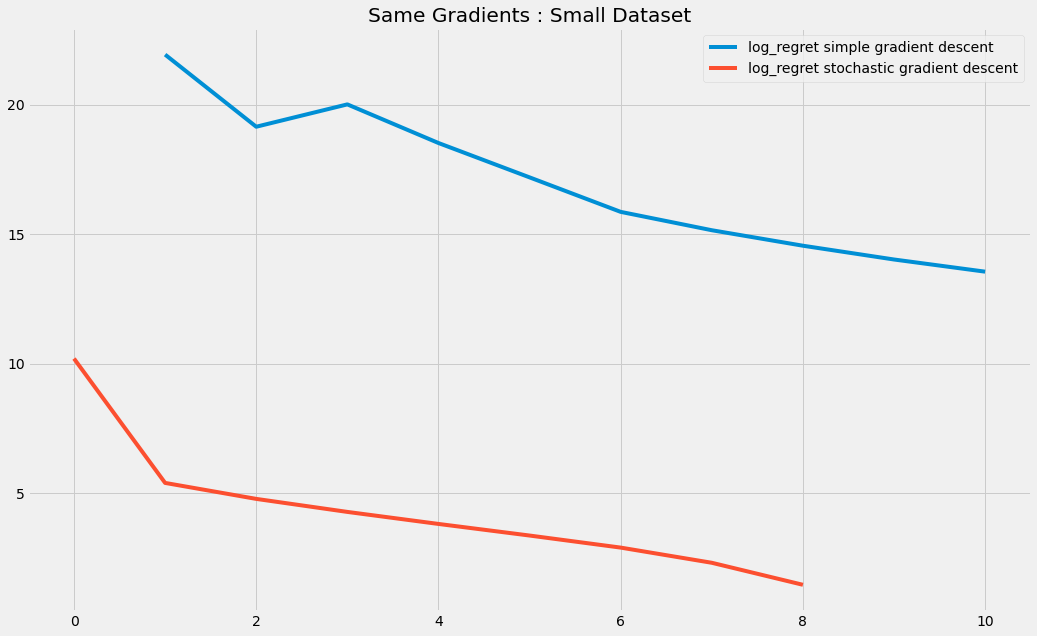

In [15]:
"""STARTING TO GENERATE PLOTS FOR OUR SMALL GRAD VS. STOCHASTIC GRAD DEMO ABOVE"""

plt.plot(np.log(param_grad[:,-1]-min(param_grad[:,-1])),label='log_regret simple gradient descent')
plt.plot(np.log((sto_by_1000 - min(sto_by_1000))),label='log_regret stochastic gradient descent')
plt.legend()
plt.title('Same Gradients : Small Dataset')


- So for the same gradient number, the stochastic gradient descent is much faster and more efficient than the classic gradient descent. This is a widely known fact but while studying Online COnvex Optimization, this becomes all the more important.

- Simple conclusion someone can draw from above is that the simple classical gradient descent requires more gradient to perform learning.

- By iteration: Always on the small database the gradient descent can learn more quickly as a batch than stochastic gradient descent can. (Heuristically)

In [16]:

param_grad = grad_descent(X_train[:1000],Y_train[:1000],np.array(784*[0]),1000,hinge_loss,1)

param_sto_grad = sto_grad_descent(X_train[:1000],Y_train[:1000],np.array(784*[0]),1000,hinge_loss,gradient,1)


100%|██████████| 1000/1000 [00:00<00:00, 2831.86it/s]


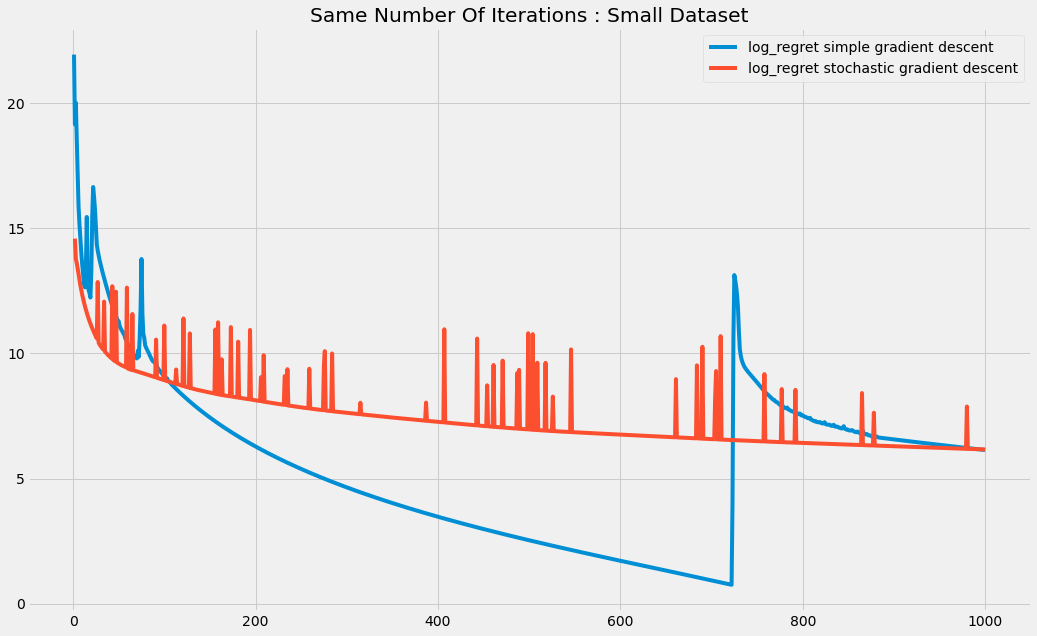

In [17]:
plt.plot(np.log(param_grad[:,-1]-min(param_grad[:,-1])),label='log_regret simple gradient descent')
plt.plot(np.log(param_sto_grad[:,-1] - min(param_sto_grad[:,-1])),label='log_regret stochastic gradient descent')
plt.title('Same Number Of Iterations : Small Dataset')
plt.legend()
plt.show()

We notice a couple of things we should explore further in this notebook.

- At the start, the stochastic gradient descent converges faster but is quickly overtaken by the classic gradient descent which is not surprising because it uses more gradient than the latter.

- Let's check this conjecture on all the data (Warning: Running next cell might take some time)

In [18]:

param_grad = grad_descent(X_train,Y_train,np.array(784*[0]),100,hinge_loss,1)

param_sto_grad= sto_grad_descent(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1)


100%|██████████| 1000/1000 [00:00<00:00, 2712.45it/s]


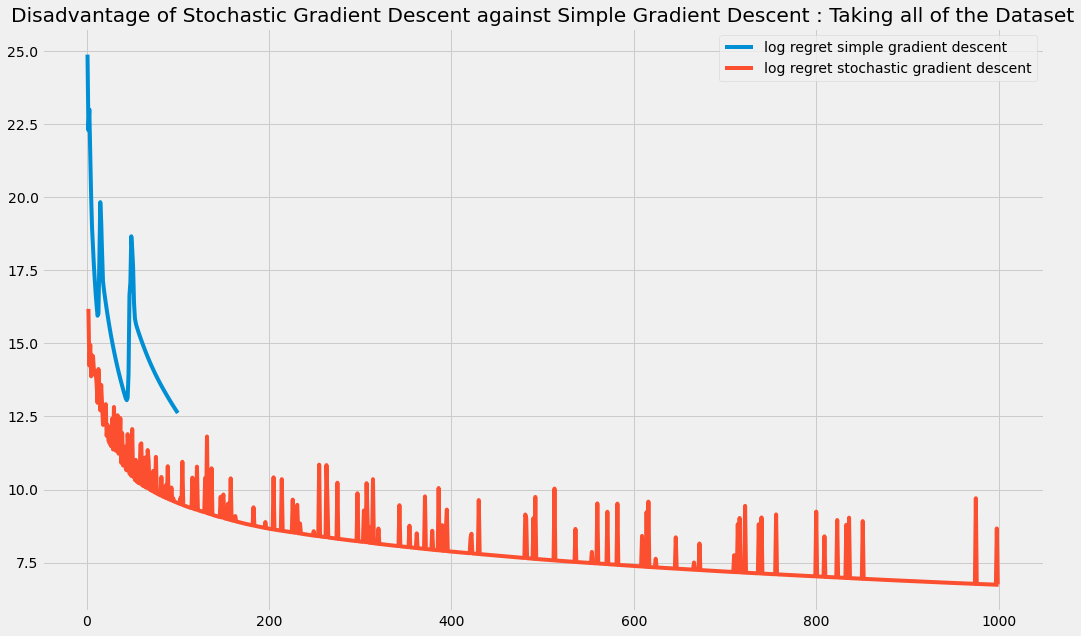

In [19]:
plt.plot(np.log(param_grad[:,-1]-min(param_grad[:,-1])),label='log regret simple gradient descent')
plt.plot(np.log(param_sto_grad[:,-1] - min(param_sto_grad[:,-1])),label='log regret stochastic gradient descent')
plt.title('Disadvantage of Stochastic Gradient Descent against Simple Gradient Descent : Taking all of the Dataset')
plt.legend()
plt.show()

So we again notice a few things after going through above analysis.

- When the database is large, the stochastic gradient descent is more efficient than the classic gradient descent in terms of iteration. 
- Classic gradient descent probably takes longer to adjust to a larger database.
- A good tradeoff between the two is to perform batch stochastic gradient descent. We will see later how OCO techniques take advantage of SGD in their own ways.


#### Now we compare the descents of stochastic gradients with projection

In [20]:
def sto_grad_descent_proj(a,b,init,iters,cost,grad,lam,s=1):
    param = np.zeros((iters + 1,len(init)+1))
    param[0,:-1] = init
    param[0,-1] = cost(init,a[0,:],b[0],lam)
    
    ind = np.random.choice(range(len(b)),iters+1)
    a = a[ind,:]
    b = b[ind]
    
    for i in tqdm.tqdm(range(0,iters)):
        eta = 2/(i+1)
        param[i+1,:-1] = euclidean_proj_l1ball(param[i,:-1] - eta * grad(param[i,:-1],a[i,:],b[i],lam),s)
        param[i+1,-1] = cost(np.mean(param[:i+1,:-1],axis=0),a[i,:],b[i],lam)
        
    return param

In [21]:
rdm.seed(1)
sto_grad = sto_grad_descent(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1)
rdm.seed(1)
sto_grad_s10 = sto_grad_descent_proj(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1,10)
rdm.seed(1)
sto_grad_s1 = sto_grad_descent_proj(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1,1)
rdm.seed(1)
sto_grad_s1000 = sto_grad_descent_proj(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1,1000)
rdm.seed(1)
sto_grad_s100 = sto_grad_descent_proj(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1,100)

100%|██████████| 1000/1000 [00:00<00:00, 2398.25it/s]


Below we indulge in these 2 steps:

- We will compare here the performances of the different projections and also their speed of convergence.

- To compare the convergence speeds, we observe the variance of the parameters at each iteration.

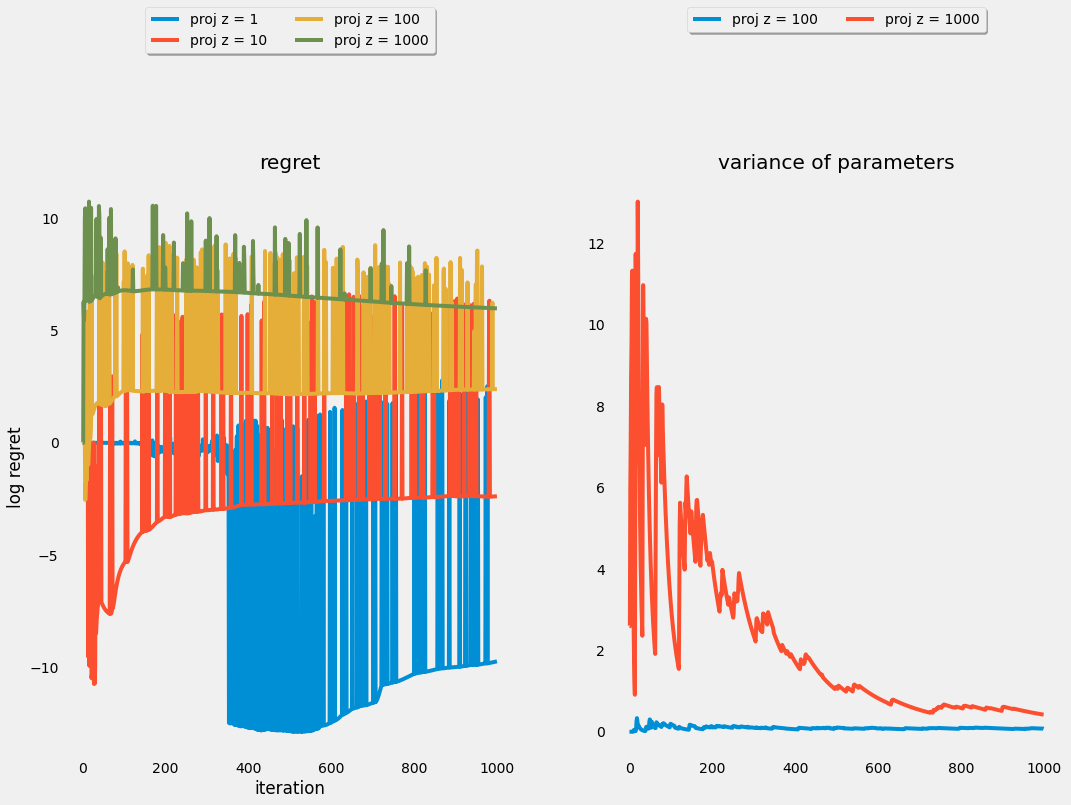

In [23]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False)  # 1 row, 2 columns

# First subplot

ax[0].plot(np.log(sto_grad_s1[:,-1]),label='proj z = 1')
ax[0].plot(np.log(sto_grad_s10[:,-1]),label='proj z = 10')
ax[0].plot(np.log(sto_grad_s100[:,-1]),label='proj z = 100')
ax[0].plot(np.log(sto_grad_s1000[:,-1]),label='proj z = 1000')
ax[0].grid()
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("log regret")
ax[0].set_title("regret")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)


# Second subplot

ax[1].plot([np.var([sto_grad_s100[i,:-1],sto_grad_s100[i+1,:-1]]) for i in range(999)],label='proj z = 100')
ax[1].plot([np.var([sto_grad_s1000[i,:-1],sto_grad_s1000[i+1,:-1]]) for i in range(999)],label='proj z = 1000')
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)
ax[1].grid()
ax[1].set_title("variance of parameters");


Below we try to get a better grasp on the convergence speeds of these algorithms depending on the dataset.

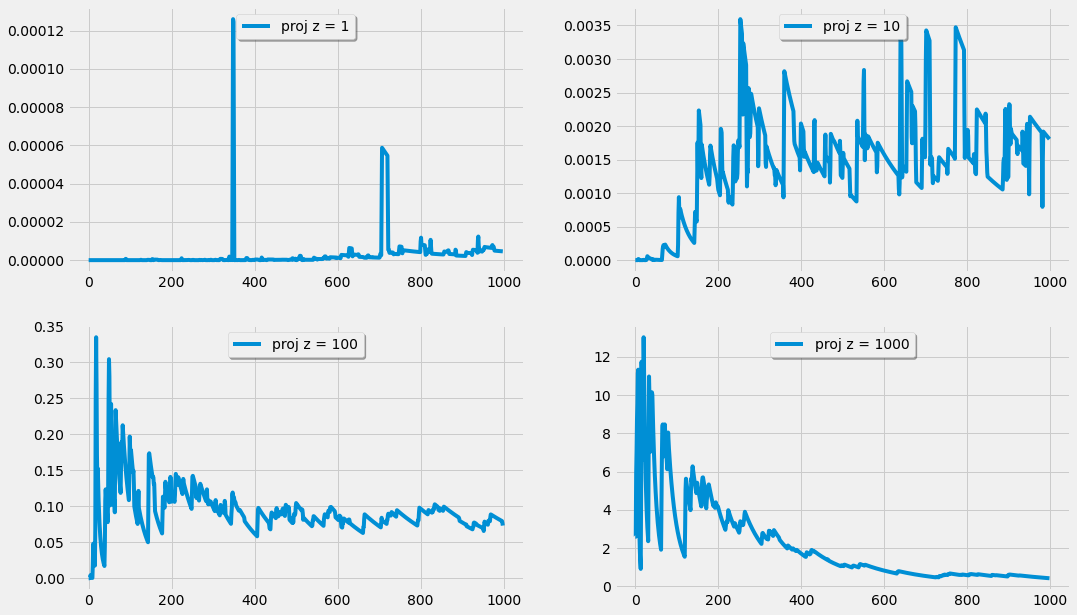

In [24]:
fig, ax = plt.subplots(2, 2, sharex='row', sharey=False)
#ax[1].plot([np.var([sto_grad[i,:-1],sto_grad[i+1,:-1]]) for i in range(999)])
ax[0,0].plot([np.var([sto_grad_s1[i,:-1],sto_grad_s1[i+1,:-1]]) for i in range(999)],label='proj z = 1')
ax[0,1].plot([np.var([sto_grad_s10[i,:-1],sto_grad_s10[i+1,:-1]]) for i in range(999)],label='proj z = 10')
ax[1,0].plot([np.var([sto_grad_s100[i,:-1],sto_grad_s100[i+1,:-1]]) for i in range(999)],label='proj z = 100')
ax[1,1].plot([np.var([sto_grad_s1000[i,:-1],sto_grad_s1000[i+1,:-1]]) for i in range(999)],label='proj z = 1000')
ax[0,0].legend(loc="upper center",  shadow=True)
ax[1,0].legend(loc="upper center",  shadow=True)
ax[0,1].legend(loc="upper center", shadow=True)
ax[1,1].legend(loc="upper center", shadow=True)

Let us compare the one which seems to converge, i.e. the projection of the descent of stochastic gradient on the ball 100 and 1000 with the descent of stochastic gradient.

Text(0.5, 1.0, 'diff projB(100) vs sto_grad_normal')

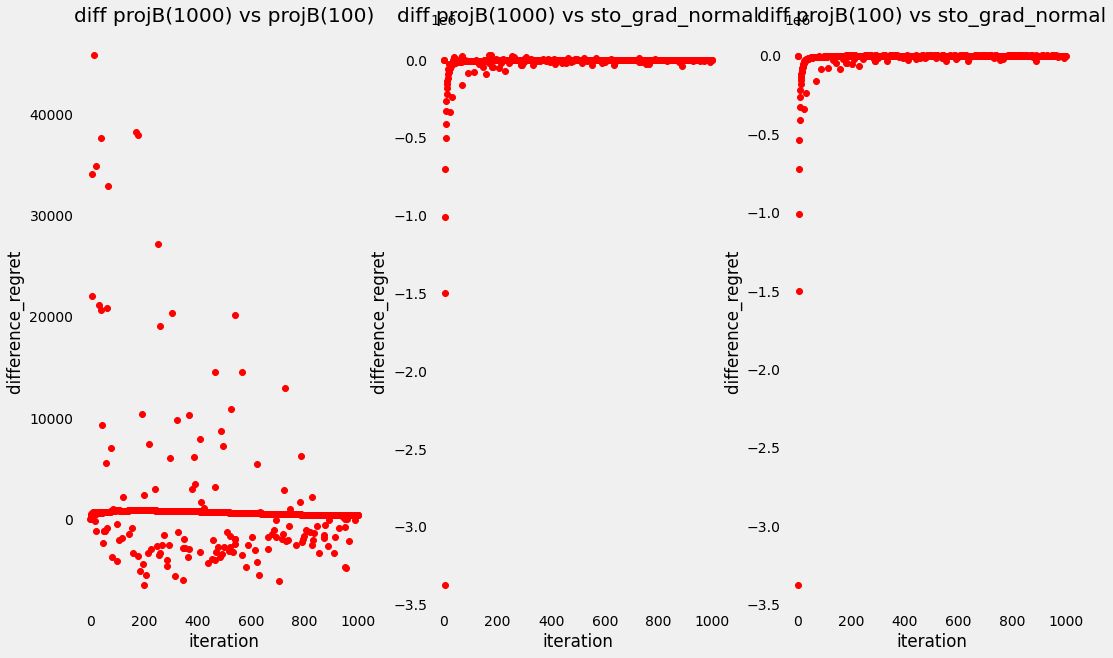

In [25]:
fig,ax = plt.subplots(1,3)
ax[0].plot(sto_grad_s1000[:,-1]-sto_grad_s100[:,-1],'ro')
ax[0].grid()
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("difference_regret ")
ax[0].set_title("diff projB(1000) vs projB(100)")
#ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

ax[1].plot(sto_grad_s1000[:,-1]-sto_grad[:,-1],'ro')
ax[1].grid()
ax[1].set_xlabel("iteration")
ax[1].set_ylabel("difference_regret ")
ax[1].set_title("diff projB(1000) vs sto_grad_normal")
#ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

ax[2].plot(sto_grad_s100[:,-1]-sto_grad[:,-1],'ro')
ax[2].grid()
ax[2].set_xlabel("iteration")
ax[2].set_ylabel("difference_regret ")
ax[2].set_title("diff projB(100) vs sto_grad_normal")
#ax[2].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

So we draw a couple of conclusions over here:

- By iteration, one notices at the beginning a difference on the projection errors 100 and 1000 with the descent of stochastic gradient. Then, one can observe a difference throughout between the two projections.

- To have a better grasp of the two performances, we will calculate the regret on the whole database by iteration for the three algorithms.

In [27]:
# let's calculate the regret on the whole database of the two best with stochastic gradients (with and without projections)

real_regret_proj1000  = [total_cost(sto_grad_s1000[i,:-1],X_train,Y_train,1) for i in tqdm.tqdm(range(999))]


real_regret_sto = [total_cost(sto_grad[i,:-1],X_train,Y_train,1) for i in tqdm.tqdm(range(999))]


real_regret_proj100 = [total_cost(sto_grad_s100[i,:-1],X_train,Y_train,1) for i in tqdm.tqdm(range(999))]



100%|██████████| 999/999 [06:13<00:00,  2.68it/s]


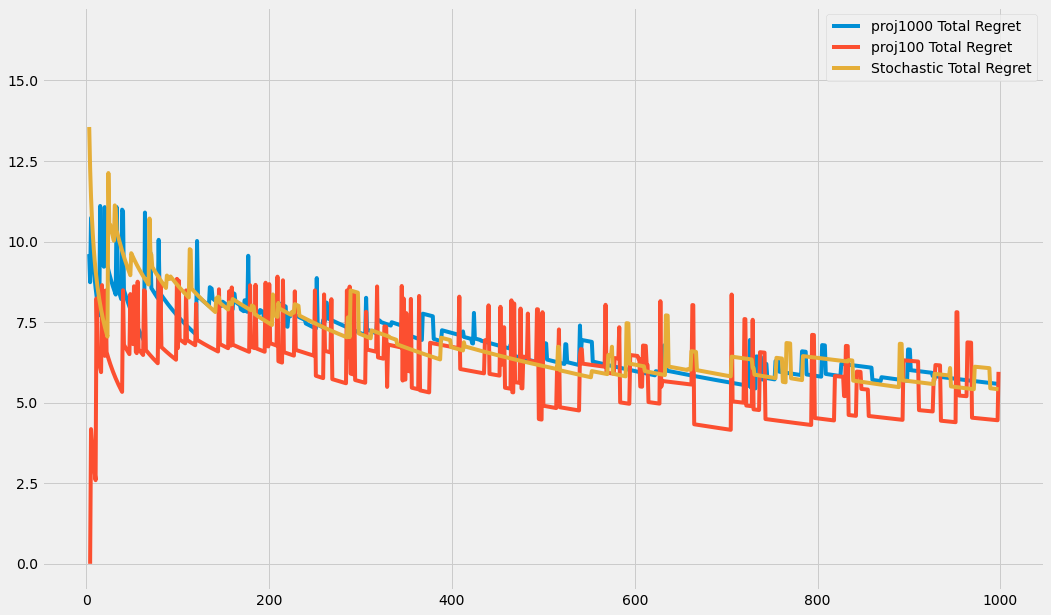

In [28]:
plt.plot(np.log(real_regret_proj1000-min(real_regret_proj1000)),label='proj1000 Total Regret')
plt.plot(np.log(real_regret_proj100-min(real_regret_proj100)),label='proj100 Total Regret')
plt.plot(np.log(real_regret_sto-min(real_regret_sto)),label='Stochastic Total Regret')
plt.legend()

A couple of conclusions can be drawn over here:

- We notice that they all seem to increase their performance but we can see that the one that leads in general is the stochastic gradient descent with the projection 100.

- To be clear, we can assert this assumption by plotting the cumulative loss.

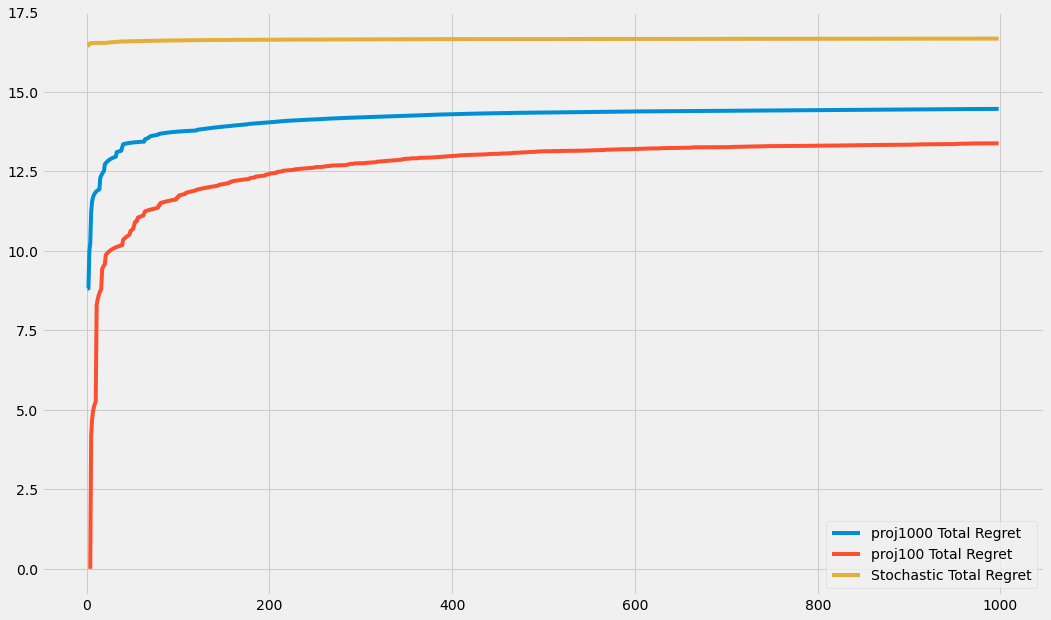

In [30]:
plt.plot(np.log(np.cumsum(real_regret_proj1000-min(real_regret_proj1000))),label='proj1000 Total Regret')
plt.plot(np.log(np.cumsum(real_regret_proj100-min(real_regret_proj100))),label='proj100 Total Regret')
plt.plot(np.log(np.cumsum(real_regret_sto-min(real_regret_sto))),label='Stochastic Total Regret')
plt.legend()

## Stochastic Gradient Descent & Stochastic Mirror Descent

References on Mirror Descent: https://www.stat.berkeley.edu/~bartlett/courses/2014fall-cs294stat260/lectures/mirror-descent-notes.pdf

Stat 260/CS 294-102. Learning in Sequential Decision Problems.

By 

Peter Bartlett

In [32]:
def sto_mirror_descent(a,b,init,iters,cost,grad,lam,s=1):
    param = np.zeros((iters + 1,len(init)+1))
    param[0,:-1] = init
    param[0,-1] = cost(init,a[0,:],b[0],lam)
    
    ind = np.random.choice(range(len(b)),iters+1)
    a = a[ind,:]
    b = b[ind]
    
    theta = init
    for i in tqdm.tqdm(range(0,iters)):
        eta = 2/(i+1)
        theta = theta - eta *(gradient(theta,a[i,:],b[i],lam)+theta)
        param[i+1,:-1] = euclidean_proj_l1ball(theta,s)
        param[i+1,-1] = cost(np.mean(param[:i+1,:-1],axis=0),a[i,:],b[i],lam)
        
    return param

In [33]:
rdm.seed(1)
param_sto = sto_grad_descent_proj(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1,3000)


rdm.seed(1)
param_mirror = sto_mirror_descent(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1,1000)


100%|██████████| 1000/1000 [00:00<00:00, 2638.50it/s]


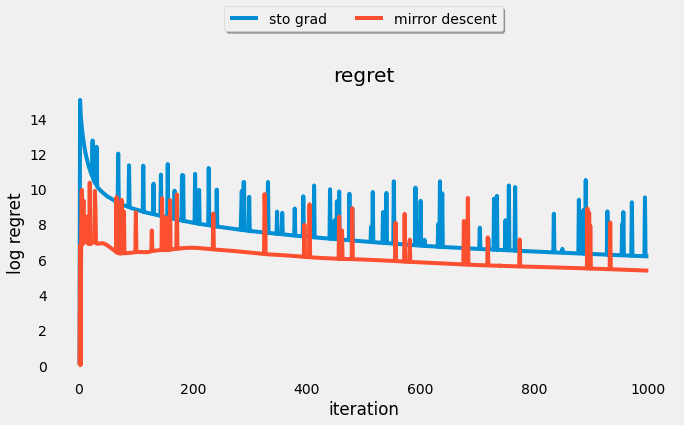

In [35]:

# Plotting and Observing the Regret and Speed of Convergence

fig, ax = plt.subplots(figsize=(10, 5))

# First subplot
#ax[0].plot(sto_grad[:,-1])

ax.plot(np.log(sto_grad[:,-1]),label='sto grad')
ax.plot(np.log(param_mirror[:,-1]),label='mirror descent')

ax.grid()
ax.set_xlabel("iteration")
ax.set_ylabel("log regret")
ax.set_title("regret")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)
# Second item


#### Let us observe the variance of the parameters of these algorithms.

Text(0.5, 1.0, 'Stochastic Mirror Descent Parameters Variance')

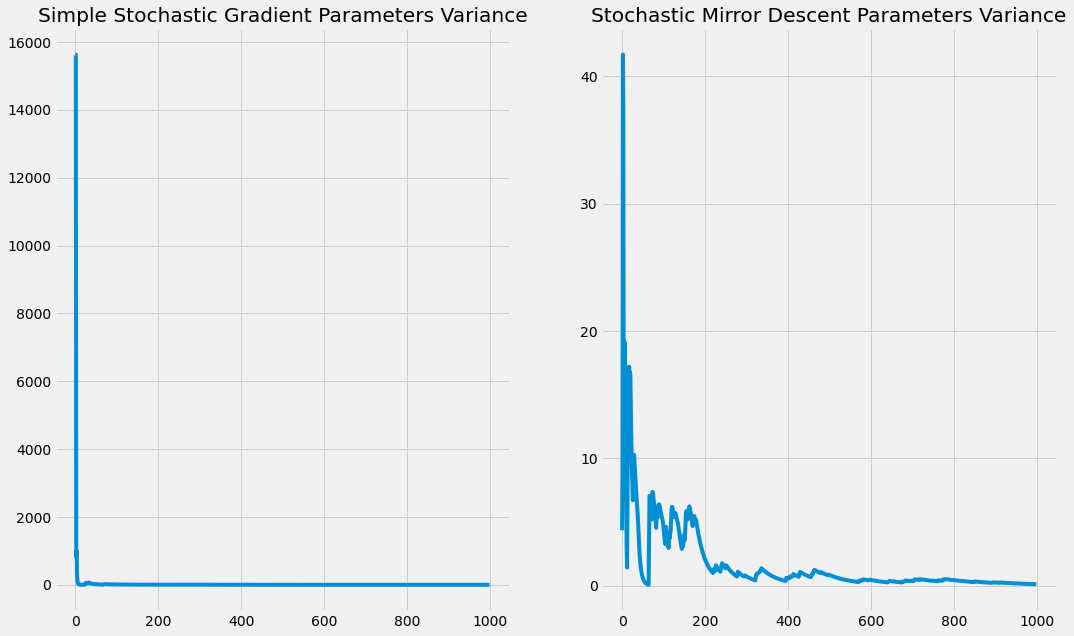

In [36]:
fig, ax = plt.subplots(1, 2, sharex='row', sharey=False)

ax[0].plot([np.var([sto_grad[i,:-1],sto_grad[i+1,:-1]]) for i in range(999)],label='proj z = 1')
ax[1].plot([np.var([param_mirror[i,:-1],param_mirror[i+1,:-1]]) for i in range(999)],label='proj z = 10')

ax[0].set_title('Simple Stochastic Gradient Parameters Variance')
ax[1].set_title('Stochastic Mirror Descent Parameters Variance')

In [37]:
"""CALCULATING THE REGRET OF STOCHASTIC MIRROR DESCENT OVER THE DATASET"""

"""RUNS FOR AROUND 5-6 MINUTES"""

real_regret_mirror = [total_cost(param_mirror[i,:-1],X_train,Y_train,1) for i in tqdm.tqdm(range(999))]

100%|██████████| 999/999 [06:17<00:00,  2.65it/s]


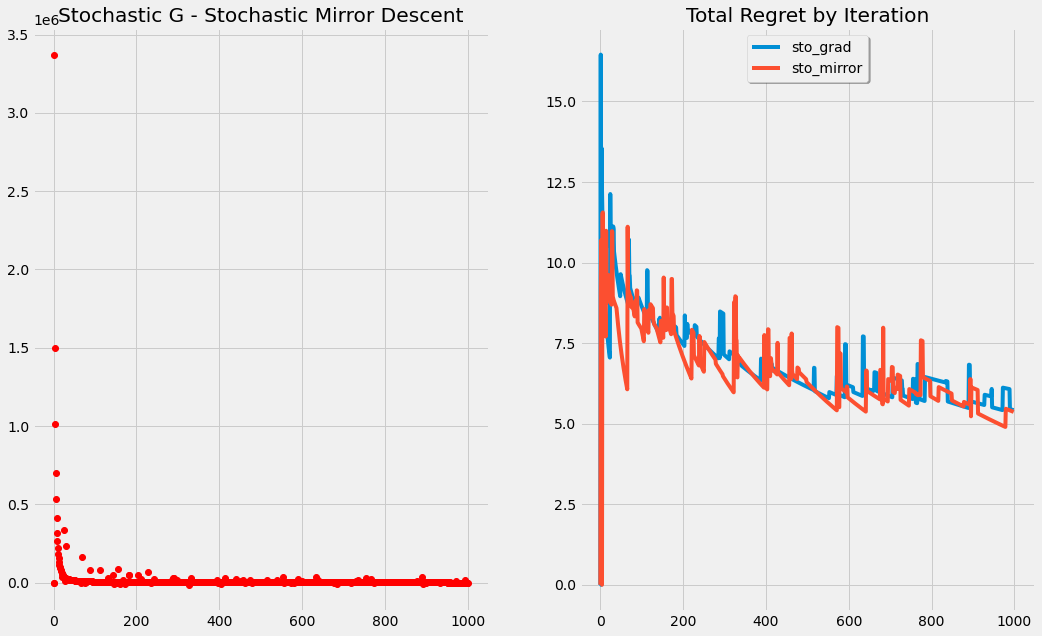

In [43]:
fig, ax = plt.subplots(1, 2, sharex='row', sharey=False)

ax[0].plot(sto_grad[:,-1] - param_mirror[:,-1], 'ro')
ax[0].set_title('Stochastic G - Stochastic Mirror Descent')

ax[1].plot(np.log(real_regret_sto),label='sto_grad')
ax[1].plot(np.log(real_regret_mirror),label='sto_mirror')
ax[1].set_title('Total Regret by Iteration')

ax[1].legend(loc="upper center", shadow=True)



Sp we conclude that the two stochastic algorithms are very close though the stochastic mirror descent seems to stand out from the other in efficiency.

## Stochastic Exponential Gradient, Randomized Exponential Gradient & Stochastic Gradient Descent

In [45]:
def sto_exp_grad_mp(a,b,iters,cost,grad,lam,s):  
    d = a.shape[1]
    r = np.ones(d)
    r_2 = np.ones(d)
    param = np.zeros((iters + 1,d+1))
    
    ind = np.random.choice(range(len(b)),iters+1)
    a = a[ind,:]
    b = b[ind]
    
    w = np.array((2*d)*[1/(2*d)])
    param[0,:-1] = s*(w[:d]-w[d:])
    param[0,-1] = cost(param[0,:-1],a[0,:],b[0],lam)
    
    eta = s*np.sqrt(np.log(d)/iters)
    
    for i in tqdm.tqdm(range(0,iters)):
        x = param[i,:-1]
        
        gr = grad(x,a[i,:],b[i],lam)+x
        # first update
        for i1 in range(d):
            r[i1] = np.exp(- eta * gr[i1])
        for i2 in range(d):
            r_2[i2] = 1/r[i2]
        for i3 in range(d):
            w[i3] = (w[i3]*r[i3])
            w[i3+d] = (w[i3+d]*r_2[i3])
        w = w/(np.sum(w))
        
        
        param[i+1,:-1] = s*(w[:d]-w[d:])
        param[i+1,-1] = cost(np.mean(param[:i+1,:-1],axis=0),a[i,:],b[i],lam)
        
    return param    

In [46]:
def rand_exp_grad_mp(a,b,iters,cost,grad,lam,s):  
    d = a.shape[1]
    r = np.ones(d)
    r_2 = np.ones(d)
    param = np.zeros((iters + 1,d+1))
    
    ind = np.random.choice(range(len(b)),iters+1)
    a = a[ind,:]
    b = b[ind]
    
    w = np.array((2*d)*[1/(2*d)])
    param[0,:-1] = s*(w[:d]-w[d:])
    param[0,-1] = cost(param[0,:-1],a[0,:],b[0],lam)
    
    eta = s*np.sqrt(np.log(d)/iters)
    
    for i in tqdm.tqdm(range(0,iters)):
        j = np.random.choice(2*d,1,replace=True,p=w)
        j = int(j)
        
        j = j % d + 1
    
        pm = 2*(j<d)-1
        x = param[i,j]
        grad_j = grad(x,a[i,j],b[i],lam) + x
        gradest = np.array(j*[0] + [pm*grad_j/w[j+1]] + (2*d-j-1)*[0])
        f = pmin(np.exp(700),np.exp(-eta*gradest))
        mise = pmax(np.exp(-700),f)

        for i2 in range(d):
            w[i2] = mise[i2]*w[i2]
            w[i2+d] = mise[i2+d]*w[i2+d]
        w = w/np.sum(w)
        param[i+1,:-1] = s*(w[:d]-w[d:])
        param[i+1,-1] = cost(np.mean(param[:i+1,:-1],axis=0),a[i,:],b[i],lam)
        
    return param    

In [48]:
rdm.seed(1)
param_pm = sto_exp_grad_mp(X_train,Y_train,1000,hinge_loss,gradient,1,1)

# rdm.seed(1)
# param_rand = rand_exp_grad_mp(X_train,Y_train,1000,hinge_loss,gradient_sca,1,1)

real_regret_pm = [total_cost(param_pm[i,:-1],X_train,Y_train,1) for i in tqdm.tqdm(range(999))]

# real_regret_rand = [total_cost(param_rand[i,:-1],X_train,Y_train,1) for i in tqdm.tqdm(range(999))]

100%|██████████| 999/999 [06:47<00:00,  2.45it/s]




#### Overview of Performance of these Algorithms

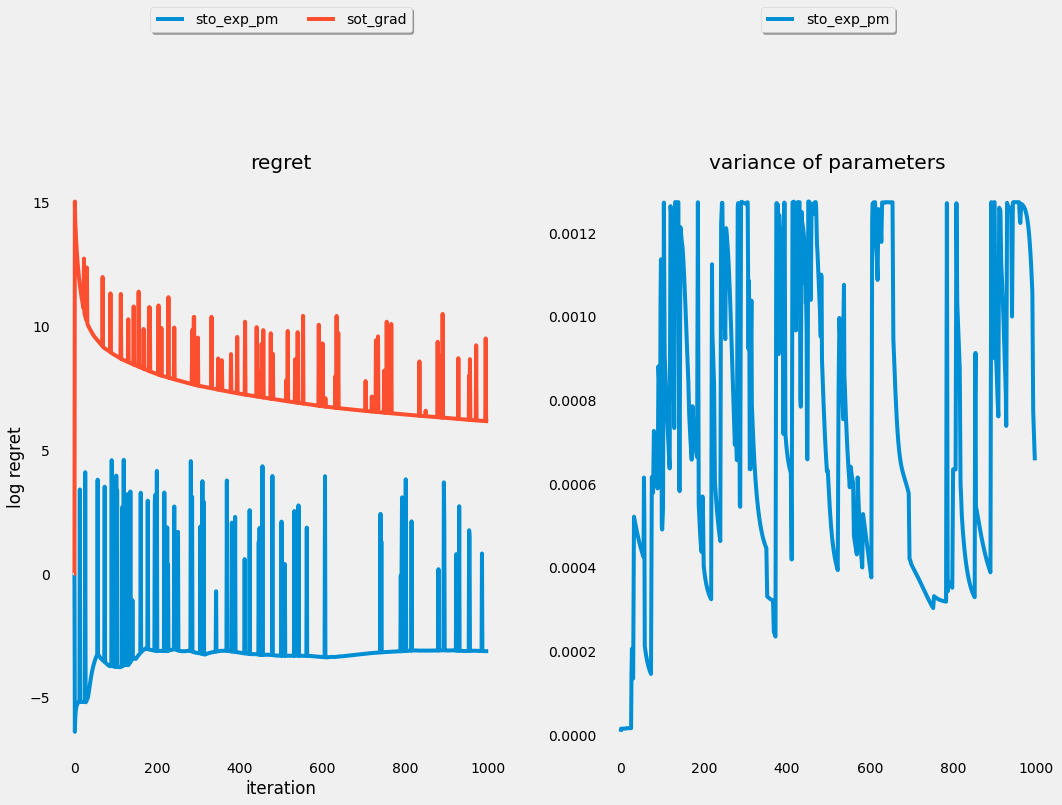

In [49]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False)  # 1 row, 2 columns

ax[0].plot(np.log(param_pm[:,-1]),label='sto_exp_pm')
# ax[0].plot(np.log(param_rand[:,-1]),label='rand_exp')
ax[0].plot(np.log(sto_grad[:,-1]),label='sot_grad')
ax[0].grid()
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("log regret")
ax[0].set_title("regret")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

ax[1].plot([np.var([param_pm[i,:-1],param_pm[i+1,:-1]]) for i in range(999)],label='sto_exp_pm')
# ax[1].plot([np.var([param_rand[i,:-1],param_rand[i+1,:-1]]) for i in range(999)],label='rand_exp')
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)
ax[1].grid()
ax[1].set_title("variance of parameters");


- Stochastic exponential algorithm more or less seems to stand out from the others. We will use this fact in further analysis that's coming up.

Text(0.5, 1.0, 'difference pm vs sto')

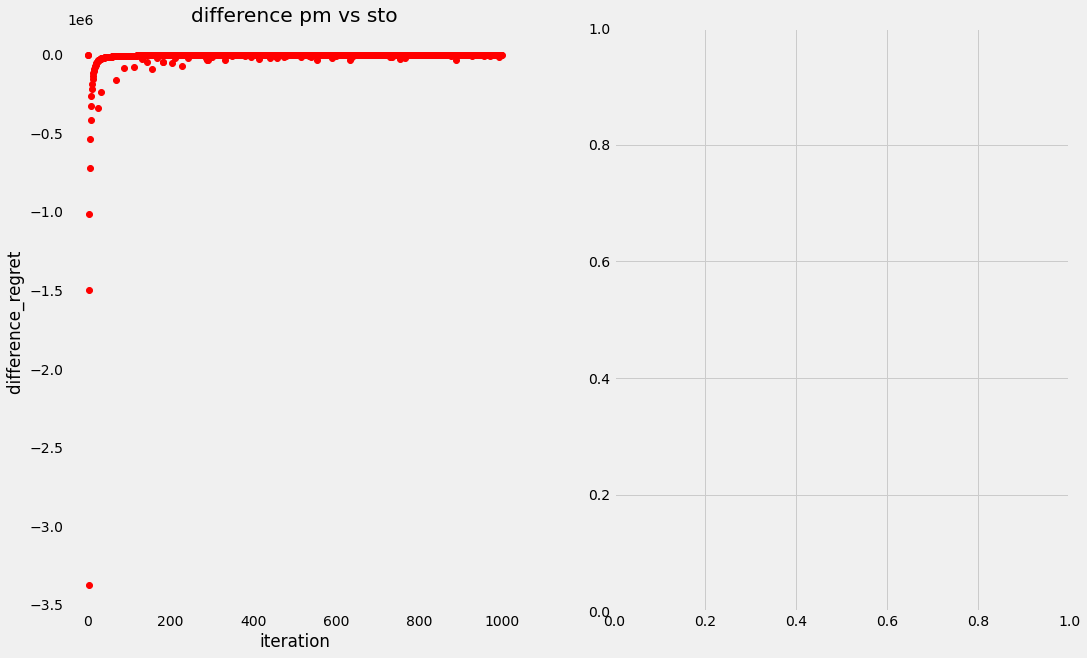

In [58]:
fig,ax = plt.subplots(1,2)
ax[0].plot(param_pm[:,-1]-sto_grad[:,-1],'ro')
ax[0].grid()
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("difference_regret ")
ax[0].set_title("difference pm vs sto")
#ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

# ax[1].plot(param_rand[:,-1]-sto_grad[:,-1],'ro')
# ax[1].grid()
# ax[1].set_xlabel("iteration")
# ax[1].set_ylabel("difference_regret ")
# ax[1].set_title("param_rand vs sto")
# #ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

# ax[2].plot(param_pm[:,-1]-param_rand[:,-1],'ro')
# ax[2].grid()
# ax[2].set_xlabel("iteration")
# ax[2].set_ylabel("difference_regret ")
# ax[2].set_title("difference pm vs rand")
# #ax[2].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

- After concluding above analysis, we can conclude that the three algorithms are quite different in their analysis and performance.

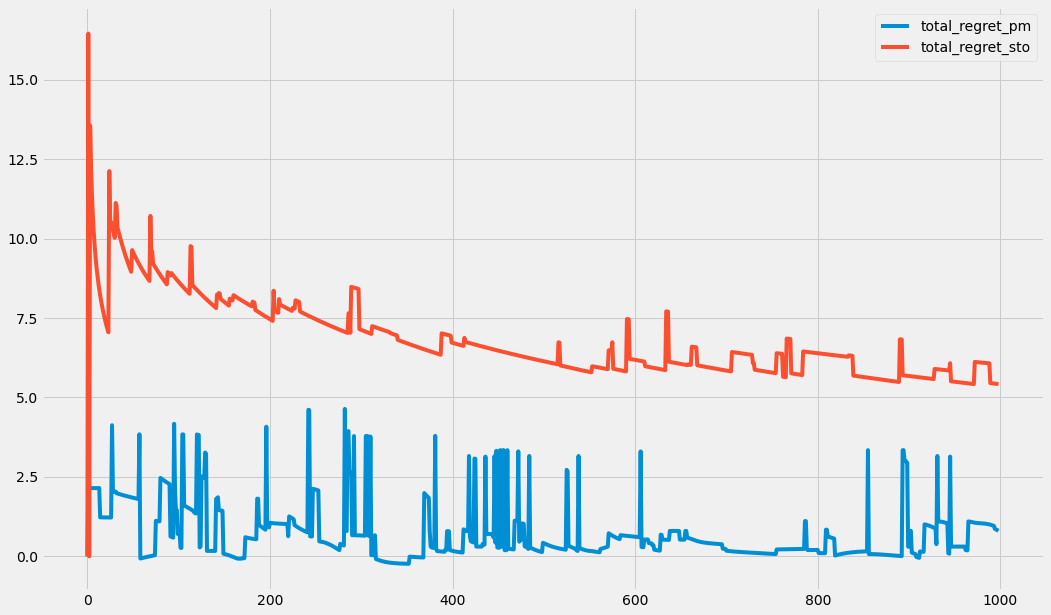

In [60]:
#general diff
plt.plot(np.log(real_regret_pm),label='total_regret_pm')
# plt.plot(np.log(real_regret_rand),label='total_regret_rand')
plt.plot(np.log(real_regret_sto),label='total_regret_sto')
plt.legend()

- This figure confirms our previous observations, because we can notice that stochastic exponential gradient is very efficient compared to the others.

## Adagrad, Online Newton Step & Stochastic Gradient Descent

In [61]:
def ada_proj(a,b,init,iters,cost,grad,lam,z=1):
    d = len(init)
    param = np.zeros((iters + 1,len(init)+1))
    param[0,:-1] = init
    param[0,-1] = cost(init,a[0,:],b[0],lam)
    
    ind = np.random.choice(range(len(b)),iters+1)
    a = a[ind,:]
    b = b[ind]
    
    s = d*[1/(4*d*z)]
    eta = 2*z
    
    for i in tqdm.tqdm(range(0,iters)):
        x = param[i,:-1]
        s = s + (gradient(x,a[i,:],b[i],lam)+x)*(gradient(x,a[i,:],b[i],lam)+x)
        y = x - eta * 1/np.sqrt(s)*(gradient(x,a[i,:],b[i],lam)+x)
        param[i+1,:-1] = proj_w(y,np.sqrt(s),z)
        param[i+1,-1] = cost(np.mean(param[:i+1,:-1],axis=0),a[i,:],b[i],lam)
        
    return param

In [62]:
def ons_proj(a,b,init,iters,cost,grad,lam,z=1):
    d = len(init)
    param = np.zeros((iters + 1,len(init)+1))
    param[0,:-1] = init
    param[0,-1] = cost(init,a[0,:],b[0],lam)
    
    ind = np.random.choice(range(len(b)),iters+1)
    a = a[ind,:]
    b = b[ind]
    
    gamm = 1/2*min(1/(8*z),1)
    s = d*[1/(gamm**2 * (2*z)**2)]
    
    for i in tqdm.tqdm(range(0,iters)):
        x = param[i,:-1]
        s = s + (gradient(x,a[i,:],b[i],lam)+x)*(gradient(x,a[i,:],b[i],lam)+x)
        y = x - (1/gamm) * (1/s) *(gradient(x,a[i,:],b[i],lam)+x)
        param[i+1,:-1] = proj_w(y,s,z)
        #param[i+1,:-1] = y
        param[i+1,-1] = cost(np.mean(param[:i+1,:-1],axis=0),a[i,:],b[i],lam)
        
    return param

In [63]:
rdm.seed(1)
param_ada = ada_proj(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1,10)

rdm.seed(1)
param_ons = ons_proj(X_train,Y_train,np.array(784*[0]),1000,hinge_loss,gradient,1,0.1)

real_regret_ada = [total_cost(param_ada[i,:-1],X_train,Y_train,1) for i in tqdm.tqdm(range(999))]

real_regret_ons = [total_cost(param_ons[i,:-1],X_train,Y_train,1) for i in tqdm.tqdm(range(999))]

100%|██████████| 999/999 [06:18<00:00,  2.64it/s]


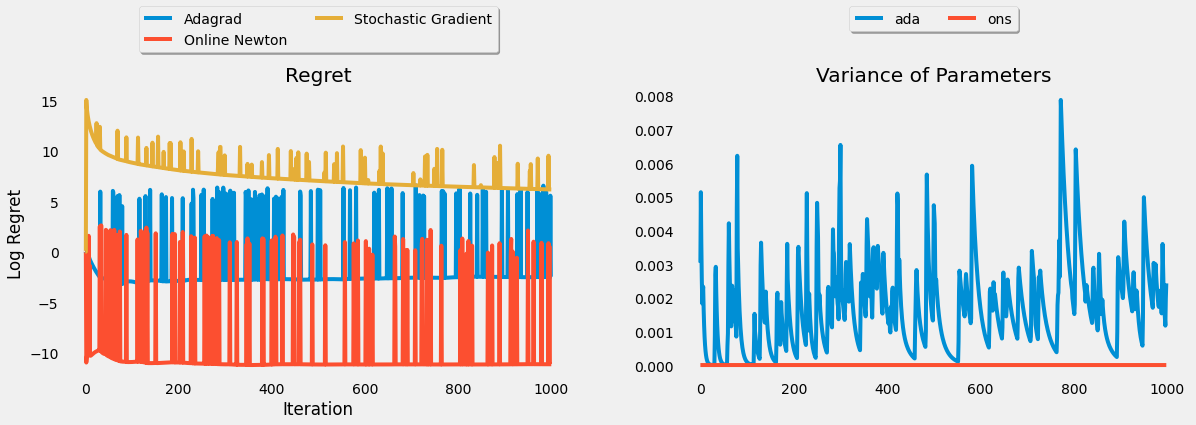

In [64]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(18, 5))  # 1 row, 2 columns

ax[0].plot(np.log(param_ada[:,-1]),label='Adagrad')
ax[0].plot(np.log(param_ons[:,-1]),label='Online Newton')
ax[0].plot(np.log(sto_grad[:,-1]),label='Stochastic Gradient')
ax[0].grid()
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Log Regret")
ax[0].set_title("Regret")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

ax[1].plot([np.var([param_ada[i,:-1],param_ada[i+1,:-1]]) for i in range(999)],label='ada')
ax[1].plot([np.var([param_ons[i,:-1],param_ons[i+1,:-1]]) for i in range(999)],label='ons')
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)
ax[1].grid()
ax[1].set_title("Variance of Parameters");


Text(0.5, 1.0, 'diff pm vs rand')

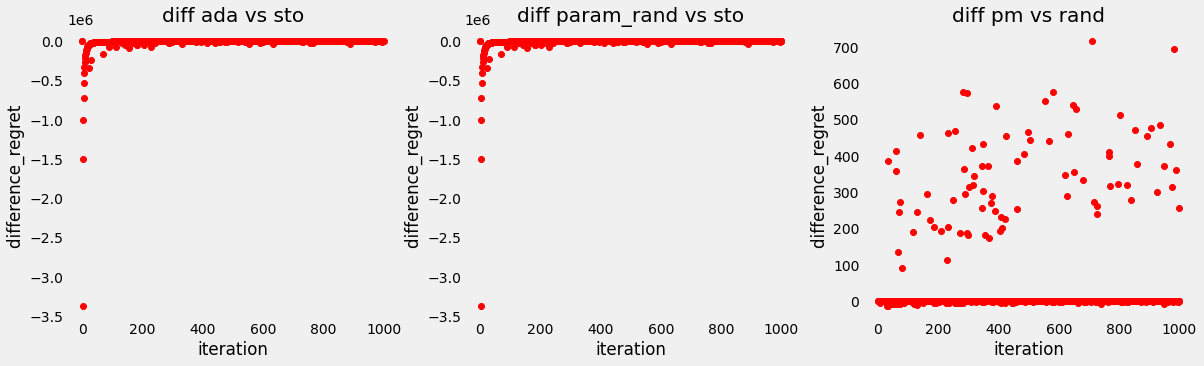

In [65]:
fig,ax = plt.subplots(1,3,figsize=(18, 5))
ax[0].plot(param_ada[:,-1]-sto_grad[:,-1],'ro')
ax[0].grid()
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("difference_regret ")
ax[0].set_title("diff ada vs sto")
#ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

ax[1].plot(param_ons[:,-1]-sto_grad[:,-1],'ro')
ax[1].grid()
ax[1].set_xlabel("iteration")
ax[1].set_ylabel("difference_regret ")
ax[1].set_title("diff param_rand vs sto")
#ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)

ax[2].plot(param_ada[:,-1]-param_ons[:,-1],'ro')
ax[2].grid()
ax[2].set_xlabel("iteration")
ax[2].set_ylabel("difference_regret ")
ax[2].set_title("diff pm vs rand")
#ax[2].legend(loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=2, shadow=True)



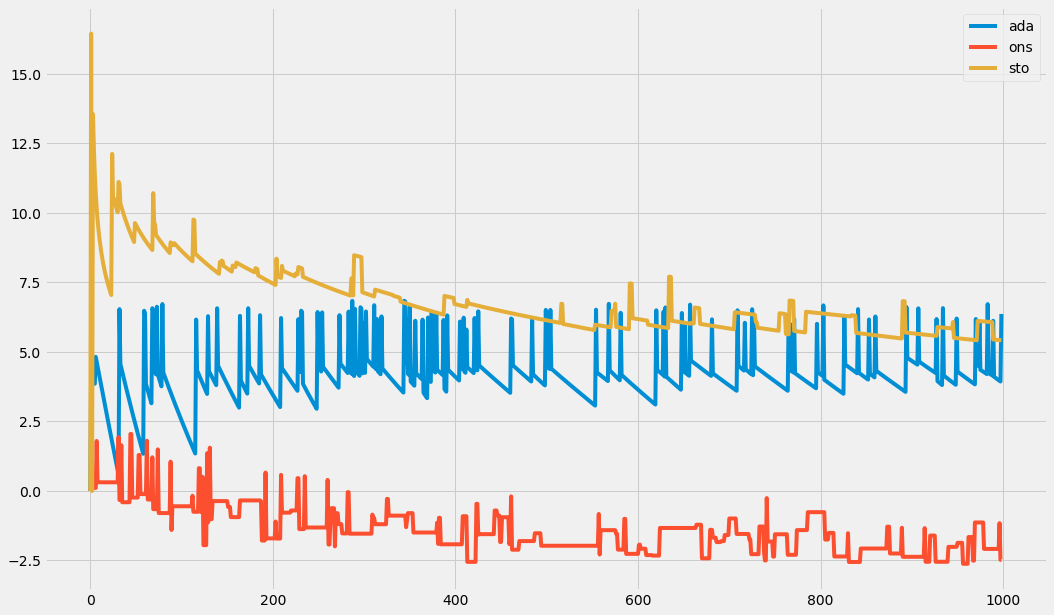

In [66]:
plt.plot(np.log(real_regret_ada),label='ada')
plt.plot(np.log(real_regret_ons),label='ons')
plt.plot(np.log(real_regret_sto),label='sto')
plt.legend()



- By doing the same, we draw the same conclusion as before. 
- In general, the three algorithms are pretty decent and different but ONLINE NEWTON STEP stands out from the others.



# Benchmarking the Algorithms with 1000 iteration (without any further parameter tuning)

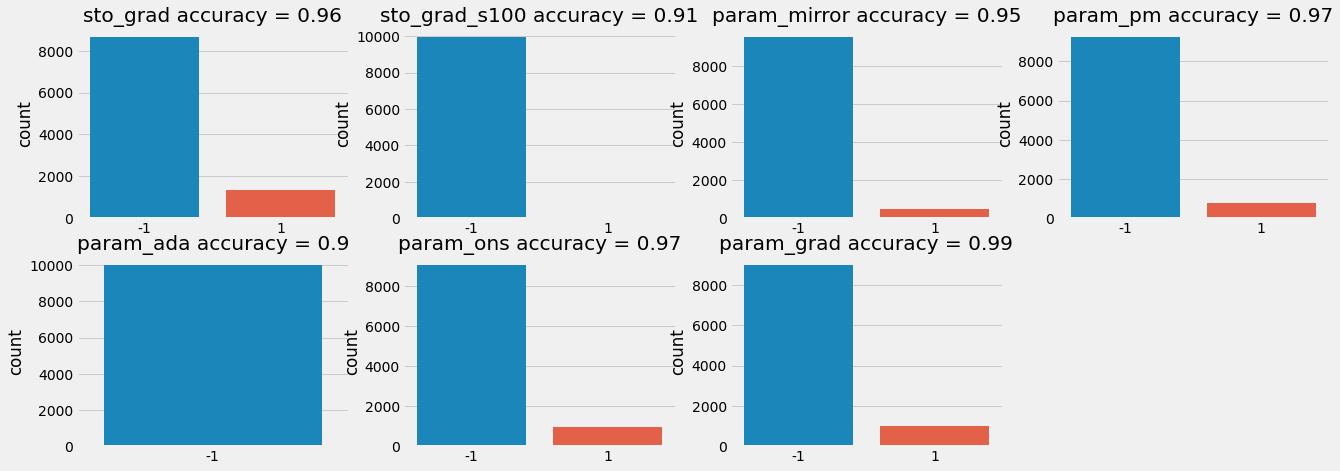

In [68]:

algo = [sto_grad,sto_grad_s100,param_mirror,param_pm,param_ada,param_ons,param_grad]

name = ['sto_grad','sto_grad_s100','param_mirror','param_pm','param_ada','param_ons','param_grad']

plt.figure(figsize=(20, 15))
for it, (na,a) in enumerate(zip(name,algo)):
    plt.subplot(4, 4, it+1)
    pred = svm_fit(a[-1,:-1],X_test)
    sns.countplot(pred)
    plt.title('{} accuracy = {}'.format(na,round(accuracy_score(pred,Y_test),2)))
    



# Let's increase the number of iterations: Benchmark with 10,000 iterations (without any further parameter tuning)

In [69]:
rdm.seed(1)
sto_grad2 = sto_grad_descent(X_train,Y_train,np.array(784*[0]),10000,hinge_loss,gradient,1)

rdm.seed(1)
sto_grad_s10002 = sto_grad_descent_proj(X_train,Y_train,np.array(784*[0]),10000,hinge_loss,gradient,1,100)

rdm.seed(1)
param_mirror2 = sto_mirror_descent(X_train,Y_train,np.array(784*[0]),10000,hinge_loss,gradient,1,1000)

rdm.seed(1)
param_pm2 = sto_exp_grad_mp(X_train,Y_train,10000,hinge_loss,gradient,1,1)

rdm.seed(1)
param_rand2 = rand_exp_grad_mp(X_train,Y_train,10000,hinge_loss,gradient_sca,1,1)

rdm.seed(1)
param_ada2 = ada_proj(X_train,Y_train,np.array(784*[0]),10000,hinge_loss,gradient,1,10)

rdm.seed(1)
param_ons2 = ons_proj(X_train,Y_train,np.array(784*[0]),10000,hinge_loss,gradient,1,0.1)

100%|██████████| 10000/10000 [00:48<00:00, 204.91it/s]


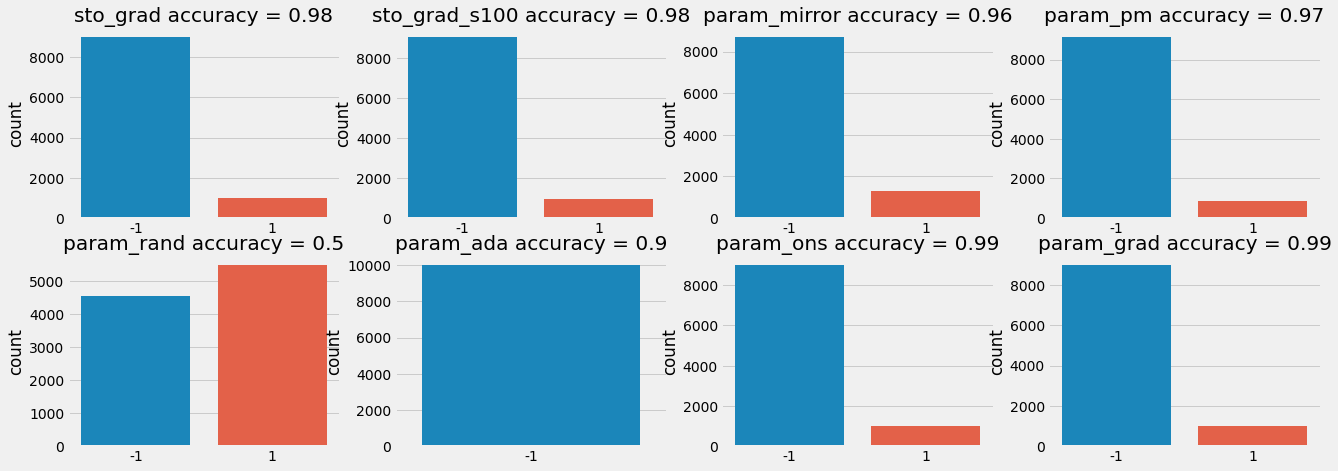

In [70]:

algo = [sto_grad2,sto_grad_s10002,param_mirror2,param_pm2,param_rand2,param_ada2,param_ons2,param_grad]
name = ['sto_grad','sto_grad_s100','param_mirror','param_pm','param_rand','param_ada','param_ons','param_grad']



plt.figure(figsize=(20, 15))
for it, (na,a) in enumerate(zip(name,algo)):
    plt.subplot(4, 4, it+1)
    pred = svm_fit(a[-1,:-1],X_test)
    sns.countplot(pred)
    plt.title('{} accuracy = {}'.format(na,round(accuracy_score(pred,Y_test),2)))
    

# Banditron

The multiclass bandit setting models a wide range of practical supervised learning applications where the learner only receives partial feedback with respect to the true label (e.g. in many web applications users often only provide positive "click" feedback which does not necessarily fully disclose a true label). The Banditron has the ability to learn in a multiclass classification setting with the "bandit" feedback which only reveals whether or not the prediction made by the algorithm was correct or not (but does not necessarily reveal the true label).

References: https://www.cs.huji.ac.il/~shais/papers/TewariShKa08.pdf

In [71]:
import datetime
import random

CATEGORY_MAPPING = ['1', '2', '3', '4', '5', '6', '7', '8', '9','10']

In [72]:
class Perceptron:

    def __init__(self):
        self.dict_length = 784
        self.weights = self.init_weights()
        self.error_rate = 0.0
        self.correct_classified = 0.0
        self.incorrect_classified = 0.0
        self.number_of_rounds = 0.0

    def init_weights(self):
        weights = []
        for i in range(0,len(CATEGORY_MAPPING)):
            weights.append([0.0] * self.dict_length)
        return weights

    def update_weights(self, update_matrix):
        for i in range(0,len(self.weights)):
            for j in range(0,len(self.weights[i])):
                self.weights[i][j] += update_matrix[i][j]

    def get_update_matrix(self, feature_vectors, calculated_label,true_label):
        update_matrix = self.init_weights()
        for i in range(0,len(update_matrix)):
            left = 0.0
            right = 0.0
            if true_label == i:
                left = 1
            if calculated_label == i:
                right = 1.0
            for j in range(0,len(feature_vectors)):
                update_matrix[i][j] = feature_vectors[j] * (left - right)
        return update_matrix

    def run(self, feature_vectors, true_label):
        self.number_of_rounds += 1.0
        calculated_label = self.predict_label(feature_vectors)

        if true_label == calculated_label:
            self.correct_classified += 1.0
        else:
            self.incorrect_classified += 1.0
        self.error_rate = self.incorrect_classified/self.number_of_rounds
       
        update_matrix = self.get_update_matrix(feature_vectors, calculated_label,true_label)
        self.update_weights(update_matrix)

    def predict_label(self, feature_vectors):
        max = 0.0
        label = 0
        for i in range(0,len(self.weights)):
            total = 0.0
            for eachVector in range(0,len(feature_vectors)):
                total += feature_vectors[eachVector]*self.weights[i][eachVector]
            if total >= max:
                max = total
                label = i
        return label

In [73]:
class Banditron:

    def __init__(self):
        self.gamma = 0.2
        self.dict_length = 784
        self.weights = self.init_weights()
        self.error_rate = 0.0
        self.correct_classified = 0.0
        self.incorrect_classified = 0.0
        self.number_of_rounds = 0.0

    def init_weights(self):
        weights = []
        for i in range(0,len(CATEGORY_MAPPING)):
            weights.append([0.0] * self.dict_length)
        return weights

    def update_weights(self, update_matrix):
        for i in range(0,len(self.weights)):
            for j in range(0,len(self.weights[i])):
                self.weights[i][j] += update_matrix[i][j]

    def get_update_matrix(self, feature_vectors, calculated_label, predicted_label, true_label, probabilities):
        update_matrix = self.init_weights()
        for i in range(0,len(update_matrix)):
            left = 0.0
            right = 0.0
            if true_label == predicted_label and predicted_label == i:
                left = 1/probabilities[i]
            if calculated_label == i:
                right = 1.0
            for j in range(0,len(feature_vectors)):
                update_matrix[i][j] = feature_vectors[j] * (left - right)
        return update_matrix

    def run(self, feature_vectors, true_label):
        self.number_of_rounds += 1.0
        calculated_label = self.predict_label(feature_vectors)
        probabilities = self.calc_probabilities(calculated_label)
        predicted_label = self.random_sample(probabilities)
        if true_label == predicted_label:
            self.correct_classified += 1.0
        else:
            self.incorrect_classified += 1.0
        self.error_rate = self.incorrect_classified/self.number_of_rounds
       
        update_matrix = self.get_update_matrix(feature_vectors, calculated_label, predicted_label, true_label, probabilities)
        self.update_weights(update_matrix)

    def predict_label(self, feature_vectors):
        max = 0.0
        label = 0
        for i in range(0,len(self.weights)):
            total = 0.0
            for eachVector in range(0,len(feature_vectors)):
                total += feature_vectors[eachVector]*self.weights[i][eachVector]
            if total >= max:
                max = total
                label = i
        return label

    def calc_probabilities(self, calculated_label):
        probabilities = [0] * len(self.weights)
        for i in range(0,len(probabilities)):
            probabilities[i] = self.gamma/len(self.weights)
            if i == calculated_label:
                probabilities[i] += (1 - self.gamma)
        return probabilities

    def random_sample(self, probabilities):
        number = random.random() * sum(probabilities)
        for i in range(0,len(probabilities)):
            if number < probabilities[i]:
                return i
                break
            number -= probabilities[i]
        return len(probabilities)-1

In [74]:
def main():
    banditron = Banditron()
    percp = Perceptron()
    error_list = list()
    rounds = list()
    error_list_p = list()
    rounds_p = list()
    for i in tqdm.tqdm(range(X_train.shape[0])):
        feature_vector = X_train[i,:]
        true_label = Y_train[i]
        banditron.run(feature_vector, true_label-1)
        percp.run(feature_vector, true_label-1)
        if ((i+1)%5) == 0:
                rounds.append(banditron.number_of_rounds)
                error_list.append(banditron.error_rate)
                rounds_p.append(percp.number_of_rounds)
                error_list_p.append(percp.error_rate)
                
 
    print ("banditron.correct_classified = ", banditron.correct_classified)
    print ("banditron.incorrect_classified = ", banditron.incorrect_classified)
    print ("banditron.error_rate = ", banditron.error_rate) 
    print ("Perceptron.correct_classified = ", percp.correct_classified)
    print ("Perceptron.incorrect_classified = ", percp.incorrect_classified)
    print ("Perceptron.error_rate = ", percp.error_rate) 
    return rounds,error_list,rounds_p,error_list_p

100%|██████████| 19999/19999 [28:21<00:00, 11.75it/s]


banditron.correct_classified =  1585.0
banditron.incorrect_classified =  18414.0
banditron.error_rate =  0.9207460373018651
Perceptron.correct_classified =  1961.0
Perceptron.incorrect_classified =  18038.0
Perceptron.error_rate =  0.9019450972548627


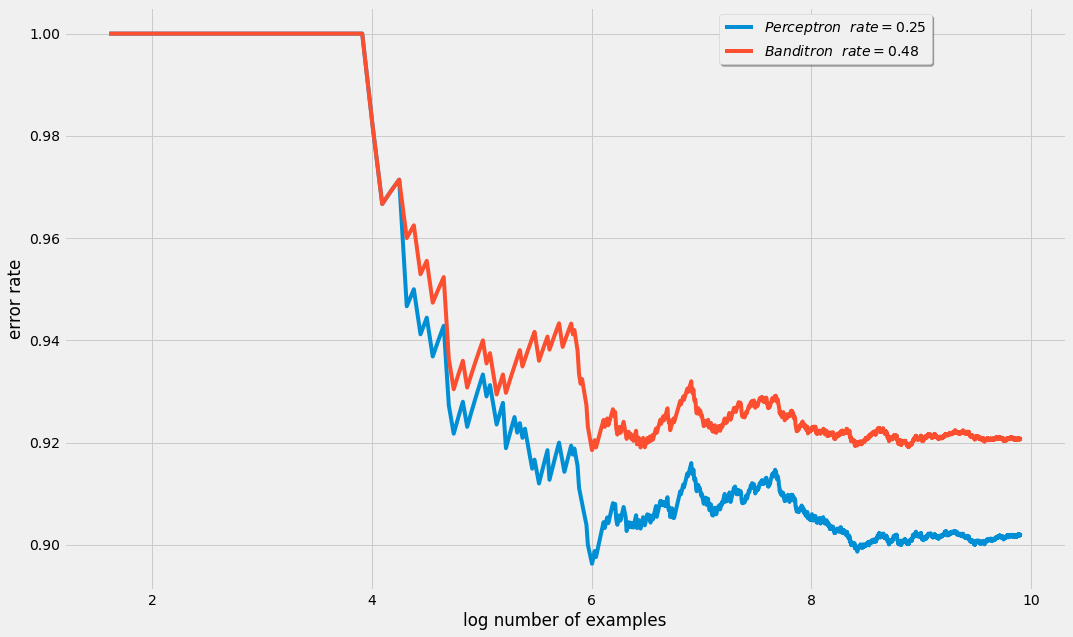

In [75]:
r,l,r_p,l_p = main()
plt.plot(np.log(r_p), l_p,label='$Perceptron\  \ rate = 0.25$')
plt.plot(np.log(r),l,label='$Banditron\  \ rate = 0.48$')
plt.ylabel('error rate')
plt.xlabel('log number of examples')
plt.legend(loc='upper center', bbox_to_anchor=(0.76, 1), shadow=True, ncol=1)
plt.savefig('banditron')
plt.show()